# House Price Prediction

**Dataset:** Use the house prices dataset ([Ames Housing Dataset](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)) from Kaggle, which have 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Lowa.

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import joblib

### Load datasets

In [25]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

### Exploratory Data Analysis

In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [27]:
# Check missing values
missing_values = df_train.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


**Visualization**

c:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


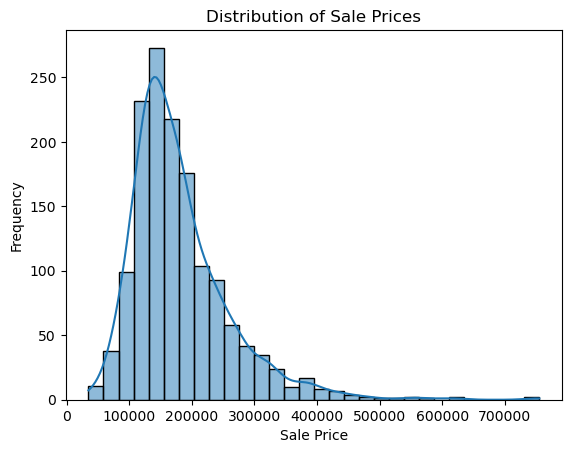

In [28]:
# Distribution of Sale Prices
sns.histplot(df_train['SalePrice'], bins=30, kde=True)
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

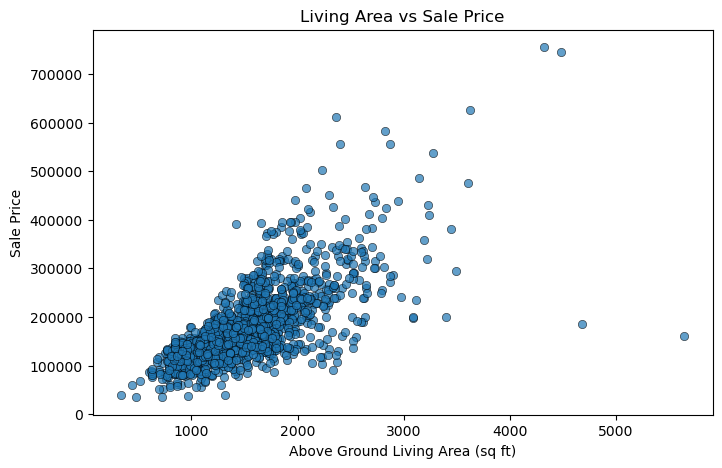

In [29]:
# Living Area vs Sale Price
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_train['GrLivArea'], y=df_train['SalePrice'], alpha=0.7, edgecolor="black")
plt.title('Living Area vs Sale Price')
plt.xlabel('Above Ground Living Area (sq ft)')
plt.ylabel('Sale Price')
plt.show()

In [30]:
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


### Feature Selection

In [31]:
selected_features = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'Neighborhood', 
                     'GarageCars', 'BsmtQual', 'KitchenQual', 'FullBath', 'LotArea']

df_train = df_train[selected_features + ['SalePrice']]
df_test = df_test[selected_features]

In [32]:
df_train

,OverallQual,GrLivArea,TotalBsmtSF,YearBuilt,Neighborhood,GarageCars,BsmtQual,KitchenQual,FullBath,LotArea,SalePrice
0,7,1710,856,2003,CollgCr,2,Gd,Gd,2,8450,208500
1,6,1262,1262,1976,Veenker,2,Gd,TA,2,9600,181500
2,7,1786,920,2001,CollgCr,2,Gd,Gd,2,11250,223500
3,7,1717,756,1915,Crawfor,3,TA,Gd,1,9550,140000
4,8,2198,1145,2000,NoRidge,3,Gd,Gd,2,14260,250000
...,...,...,...,...,...,...,...,...,...,...,...
1455,6,1647,953,1999,Gilbert,2,Gd,TA,2,7917,175000
1456,6,2073,1542,1978,NWAmes,2,Gd,TA,2,13175,210000
1457,7,2340,1152,1941,Crawfor,1,TA,Gd,2,9042,266500
1458,5,1078,1078,1950,NAmes,1,TA,Gd,1,9717,142125


**Ordinal Encoding & Handling missing values**

In [33]:
ordinal_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0}
df_train['BsmtQual'] = df_train['BsmtQual'].map(ordinal_mapping).fillna(0)
df_train['KitchenQual'] = df_train['KitchenQual'].map(ordinal_mapping).fillna(0)
df_test['BsmtQual'] = df_test['BsmtQual'].map(ordinal_mapping).fillna(0)
df_test['KitchenQual'] = df_test['KitchenQual'].map(ordinal_mapping).fillna(0)

imputer = SimpleImputer(strategy='median')
df_train[['TotalBsmtSF', 'GarageCars', 'LotArea']] = imputer.fit_transform(df_train[['TotalBsmtSF', 'GarageCars', 'LotArea']])
df_test[['TotalBsmtSF', 'GarageCars', 'LotArea']] = imputer.transform(df_test[['TotalBsmtSF', 'GarageCars', 'LotArea']])

C:\Users\PC\AppData\Local\Temp\ipykernel_2028\2136530399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['BsmtQual'] = df_train['BsmtQual'].map(ordinal_mapping).fillna(0)
C:\Users\PC\AppData\Local\Temp\ipykernel_2028\2136530399.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['KitchenQual'] = df_train['KitchenQual'].map(ordinal_mapping).fillna(0)
C:\Users\PC\AppData\Local\Temp\ipykernel_2028\2136530399.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [34]:
df_train

,OverallQual,GrLivArea,TotalBsmtSF,YearBuilt,Neighborhood,GarageCars,BsmtQual,KitchenQual,FullBath,LotArea,SalePrice
0,7,1710,856.0,2003,CollgCr,2.0,4,4,2,8450.0,208500
1,6,1262,1262.0,1976,Veenker,2.0,4,3,2,9600.0,181500
2,7,1786,920.0,2001,CollgCr,2.0,4,4,2,11250.0,223500
3,7,1717,756.0,1915,Crawfor,3.0,3,4,1,9550.0,140000
4,8,2198,1145.0,2000,NoRidge,3.0,4,4,2,14260.0,250000
...,...,...,...,...,...,...,...,...,...,...,...
1455,6,1647,953.0,1999,Gilbert,2.0,4,3,2,7917.0,175000
1456,6,2073,1542.0,1978,NWAmes,2.0,4,3,2,13175.0,210000
1457,7,2340,1152.0,1941,Crawfor,1.0,3,4,2,9042.0,266500
1458,5,1078,1078.0,1950,NAmes,1.0,3,4,1,9717.0,142125


**Encoding categorical variable**

In [35]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_neighborhood = pd.DataFrame(encoder.fit_transform(df_train[['Neighborhood']]).toarray(),
                                     columns=encoder.get_feature_names_out())
df_train = df_train.drop(columns=['Neighborhood']).join(encoded_neighborhood)

encoded_neighborhood_test = pd.DataFrame(encoder.transform(df_test[['Neighborhood']]).toarray(),
                                         columns=encoder.get_feature_names_out())
df_test = df_test.drop(columns=['Neighborhood']).join(encoded_neighborhood_test)

# Save encoder for future use in app.py
with open("neighborhood_encoder.pkl", "wb") as f:
    joblib.dump(encoder, f)

In [36]:
df_train

,OverallQual,GrLivArea,TotalBsmtSF,YearBuilt,GarageCars,BsmtQual,KitchenQual,FullBath,LotArea,SalePrice,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,7,1710,856.0,2003,2.0,4,4,2,8450.0,208500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,1262,1262.0,1976,2.0,4,3,2,9600.0,181500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7,1786,920.0,2001,2.0,4,4,2,11250.0,223500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,1717,756.0,1915,3.0,3,4,1,9550.0,140000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,2198,1145.0,2000,3.0,4,4,2,14260.0,250000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,1647,953.0,1999,2.0,4,3,2,7917.0,175000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1456,6,2073,1542.0,1978,2.0,4,3,2,13175.0,210000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1457,7,2340,1152.0,1941,1.0,3,4,2,9042.0,266500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1458,5,1078,1078.0,1950,1.0,3,4,1,9717.0,142125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Log transform skewed features**

In [37]:
df_train['LotArea'] = np.log1p(df_train['LotArea'])
df_train['GrLivArea'] = np.log1p(df_train['GrLivArea'])
df_train['TotalBsmtSF'] = np.log1p(df_train['TotalBsmtSF'])
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

df_test['LotArea'] = np.log1p(df_test['LotArea'])
df_test['GrLivArea'] = np.log1p(df_test['GrLivArea'])
df_test['TotalBsmtSF'] = np.log1p(df_test['TotalBsmtSF'])

In [38]:
df_train

,OverallQual,GrLivArea,TotalBsmtSF,YearBuilt,GarageCars,BsmtQual,KitchenQual,FullBath,LotArea,SalePrice,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,7,7.444833,6.753438,2003,2.0,4,4,2,9.042040,12.247699,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,7.141245,7.141245,1976,2.0,4,3,2,9.169623,12.109016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7,7.488294,6.825460,2001,2.0,4,4,2,9.328212,12.317171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,7.448916,6.629363,1915,3.0,3,4,1,9.164401,11.849405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,7.695758,7.044033,2000,3.0,4,4,2,9.565284,12.429220,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,7.407318,6.860664,1999,2.0,4,3,2,8.976894,12.072547,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1456,6,7.637234,7.341484,1978,2.0,4,3,2,9.486152,12.254868,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1457,7,7.758333,7.050123,1941,1.0,3,4,2,9.109746,12.493133,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1458,5,6.983790,6.983790,1950,1.0,3,4,1,9.181735,11.864469,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Standardizing numerical features**

In [39]:
# scaler = StandardScaler()
# numerical_features = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'GarageCars', 'FullBath', 'LotArea']
# df_train[numerical_features] = scaler.fit_transform(df_train[numerical_features])
# df_test[numerical_features] = scaler.transform(df_test[numerical_features])

### Model Selection & Training

In [48]:
# Splitting dataset
X = df_train.drop(columns=['SalePrice'])
y = df_train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1. Linear Regression

In [49]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print('Linear Regression MSE:', mean_squared_error(y_test, lr_preds))

Linear Regression MSE: 0.023366035823265796


### 2. Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print('Random Forest MSE:', mean_squared_error(y_test, rf_preds))

Random Forest MSE: 0.02510383327553711


### 3. XGBoost

In [43]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
print('XGBoost MSE:', mean_squared_error(y_test, xgb_preds))

XGBoost MSE: 0.02693399460660223


**Root Mean Squared Log Error (RMSLE)**

In [44]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

print('Linear Regression RMSLE:', rmsle(y_test, lr_preds))
print('Random Forest RMSLE:', rmsle(y_test, rf_preds))
print('XGBoost RMSLE:', rmsle(y_test, xgb_preds))

Linear Regression RMSLE: 0.012020494662150756
Random Forest RMSLE: 0.012507662054253566
XGBoost RMSLE: 0.012983916222542132


### Save the Model

In [51]:
best_model = lr
joblib.dump(best_model, 'house_price_model.pkl')

['house_price_model.pkl']

### Generate Submission

In [46]:
final_preds = np.expm1(lr.predict(df_test))
df_sample_submission = pd.read_csv('dataset/sample_submission.csv')
df_sample_submission['SalePrice'] = final_preds
df_sample_submission.to_csv('dataset/submission.csv', index=False)

---